# Neural decoding: position on a multi-arm track

Here is a full example of using the tools in the `compressed_kde.decode` module to perform spike-sorting-less decoding of a subject's position in a maze from spiking activity recorded on multiple tetrodes. To check decoding performance, we perform cross-validation in which each trial is used in turn to test the encoding model that is built from the other trials.

## imports

In [1]:
# import numerical libraries
import numpy as np
import scipy.interpolate
import os

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import yaml

# Fklab-python-core tool 
#-----------------------

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# Py-compressed-kde package
# -------------------------

# finally, import the decoding tools
import compressed_kde
from compressed_kde import decode

In [2]:
import pathlib 

datafile = "processed_data.hdf5"
#datafile = pathlib.Path("~/notebook_data_cache/decoding").expanduser().joinpath(filename)
force_update = False

In [21]:
# Data can be found directly on OSF : https://osf.io/emq57 - No account needed  
# or download with the osf client code below. First, `pip install osfclient`
#if not datafile.exists() or force_update:
#    client = osfclient.OSF()
#    project = client.project("fgmj8")
#    update = False
#    
#    for file in project.storage().files:
#        if file.name == filename:
#            update = True
#            with datafile.open("wb") as fp:
#                file.write_to(fp)
#            break
#    
#    if not update:
#        raise(FileNotFoundError(f"{filename} not found in the OSF project - contact the administrator of the project about it."))
#else:
#    print("I will use the dataset already present on this path. Next time, switch force_update to True if you want to update it anyway")

## define parameters
Here we set parameters for data processing and decoding.

In [3]:
# define trial epochs
trials = fklab.segments.Segment(
    [[2100, 2250], [2250, 2355], [2355, 2455], [2455, 2550], [2550, 2650]]
)
ntrials = len(trials)

# select spike data
tt_selection = [
    "TT1",
    "TT15",
    "TT16",
    "TT17",
    "TT19",
    "TT20",
    "TT23",
    "TT24",
    "TT5",
]  # tetrodes to be used for decoding
amp_threshold = (
    70.0  # uV, only use spikes with maximum amplitude larger than this threshold
)

# set kernel bandwidths and compression for encoding
pos_bw = 5.0  # cm, default spatial kernel bandwidth
amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
compression = 1.0  # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
fine_grid_resolution = 2.0
# cm, spatial grid used to build squared distance matrix
grid_resolution = 4.0
# cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 25.0  # Hz, sampling frequency of position tracking
speed_threshold = 10.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.1  # seconds, bin size for run decoding

## maze definition and evaluation grid
Here we define the maze. Since the maze has multiple sections that meet at choice point, the maze is represented as a graph. Distances on the graph cannot simply be computed as the difference between (linearized) positions, so we precompute a squared distance matrix for a set of finely spaced linearized points on the maze.

In [4]:
# define full maze
maze = "maze:\n  comments: ''\n  shapes:\n    track:\n      tags: [track]\n      comments: ''\n      shape: !graph_shape\n        nodes:\n        - [233.0, 145.0]\n        - [184.0, 145.0]\n        - [174.0, 168.0]\n        - [172.0, 120.0]\n        - [87.0, 245.0]\n        - [138.0, 0.0]\n        polylines:\n        - !polyline_shape\n          vertices:\n          - [233.0, 145.0]\n          - [184.0, 145.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [174.0, 168.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [172.0, 120.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [174.0, 168.0]\n          - [87.0, 245.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [172.0, 120.0]\n          - [138.0, 0.0]\n          spline: false\n    start:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [230.95882352941175, 144.93529411764706]\n        size: [40.92690758786794, 47.01063709417264]\n        orientation: 0.021273386024061366\n    B:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [142.0, 14.000000000000016]\n        size: [44.384682042344295]\n        orientation: 2.891149563978441\n    A:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [97.0, 238.0]\n        size: [42.5205832509386]\n        orientation: 2.4227626539681686\n"
maze = yaml.unsafe_load(maze) #load a shape object directly - as to be an unsafe load

# construct fine grid for complete track and compute squared distance matrix
fine_grid = np.arange(
    0, maze["maze"]["shapes"]["track"]["shape"].pathlength, fine_grid_resolution
)
fine_gridx, fine_gridy = np.meshgrid(fine_grid, fine_grid)
distances = (
    maze["maze"]["shapes"]["track"]["shape"].distance(fine_gridx, fine_gridy) ** 2
)

In [36]:
maze = "maze:\n  comments: ''\n  shapes:\n    track:\n      tags: [track]\n      comments: ''\n      shape: !graph_shape\n        nodes:\n        - [233.0, 145.0]\n        - [184.0, 145.0]\n        - [174.0, 168.0]\n        - [172.0, 120.0]\n        - [87.0, 245.0]\n        - [138.0, 0.0]\n        polylines:\n        - !polyline_shape\n          vertices:\n          - [233.0, 145.0]\n          - [184.0, 145.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [174.0, 168.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [172.0, 120.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [174.0, 168.0]\n          - [87.0, 245.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [172.0, 120.0]\n          - [138.0, 0.0]\n          spline: false\n    start:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [230.95882352941175, 144.93529411764706]\n        size: [40.92690758786794, 47.01063709417264]\n        orientation: 0.021273386024061366\n    B:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [142.0, 14.000000000000016]\n        size: [44.384682042344295]\n        orientation: 2.891149563978441\n    A:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [97.0, 238.0]\n        size: [42.5205832509386]\n        orientation: 2.4227626539681686\n"
print(maze)

maze:
  comments: ''
  shapes:
    track:
      tags: [track]
      comments: ''
      shape: !graph_shape
        nodes:
        - [233.0, 145.0]
        - [184.0, 145.0]
        - [174.0, 168.0]
        - [172.0, 120.0]
        - [87.0, 245.0]
        - [138.0, 0.0]
        polylines:
        - !polyline_shape
          vertices:
          - [233.0, 145.0]
          - [184.0, 145.0]
          spline: false
        - !polyline_shape
          vertices:
          - [184.0, 145.0]
          - [174.0, 168.0]
          spline: false
        - !polyline_shape
          vertices:
          - [184.0, 145.0]
          - [172.0, 120.0]
          spline: false
        - !polyline_shape
          vertices:
          - [174.0, 168.0]
          - [87.0, 245.0]
          spline: false
        - !polyline_shape
          vertices:
          - [172.0, 120.0]
          - [138.0, 0.0]
          spline: false
    start:
      tags: [field, ' reward']
      comments: ''
      shape: !rectangle_shape
    

In [30]:
maze

OrderedDict([('maze',
              OrderedDict([('comments', ''),
                           ('shapes',
                            OrderedDict([('track',
                                          OrderedDict([('tags', ['track']),
                                                       ('comments', ''),
                                                       ('shape',
                                                        graph with 6 nodes and 5 edges)])),
                                         ('start',
                                          OrderedDict([('tags',
                                                        ['field', ' reward']),
                                                       ('comments', ''),
                                                       ('shape',
                                                        rectangle (size=[40.92690758786794,47.01063709417264], center=[230.95882352941175,144.93529411764706], orientation=0.021273386024061366 rad))])),
    

## preprocess behavioral and spiking data
Here we load the data and map (x,y) coordinates to (linearized) position on the maze. Since we use a distance matrix, we then need to map linearized position to indices into the fine grid that was used to compute the distance matrix.

In [5]:
# load behavioral and ephys data
f = h5py.File(datafile, "r")
behavior = f["training/behavior"]
# map all xy positions to maze
linear_pos = maze["maze"]["shapes"]["track"]["shape"].point2path(
    behavior["positionsXY"][:]
)[0]
# map linearized positions to the fine grid vector
pos = scipy.interpolate.interp1d(
    fine_grid, np.arange(len(fine_grid)), kind="nearest", bounds_error=False
)(linear_pos)

# create nearest neighbor interpolator for mapped positions for future use
linear_pos_interpolator = scipy.interpolate.interp1d(
    behavior["time"], linear_pos, kind="nearest", bounds_error=False
)
pos_interpolator = scipy.interpolate.interp1d(
    behavior["time"], pos, kind="nearest", bounds_error=False
)

In [7]:
len(pos)

13122

Next, we extract the times and amplitudes for all spikes on the selected tetrodes that meet the minimum amplitude requirement.

In [8]:
# for each selected tetrodes extract the times and amplitudes for all
# spikes with maximum amplitude larger than threshold
tt_data = f["training/ephys/MUA/tetrodes"]
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    selection = [
        np.max(tt_data[tt][1:, :], axis=0) > amp_threshold for tt in tt_selection
    ]
tt_time = [tt_data[tt][:][0, sel] for tt, sel in zip(tt_selection, selection)]
tt_amp = [tt_data[tt][:][1:, sel].T for tt, sel in zip(tt_selection, selection)]
tt_pos = [pos_interpolator(t)[:, None] for t in tt_time]

And we construct a list of run epochs where the subject ran faster than the speed threshold.

In [9]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        behavior["speed"][:] > speed_threshold, behavior["time"][:]
    )

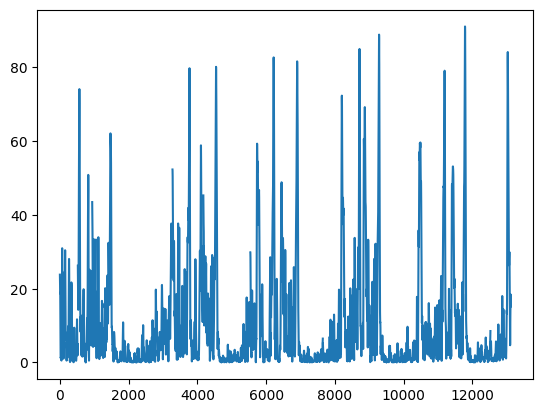

In [9]:
plt.plot(behavior["speed"][:])

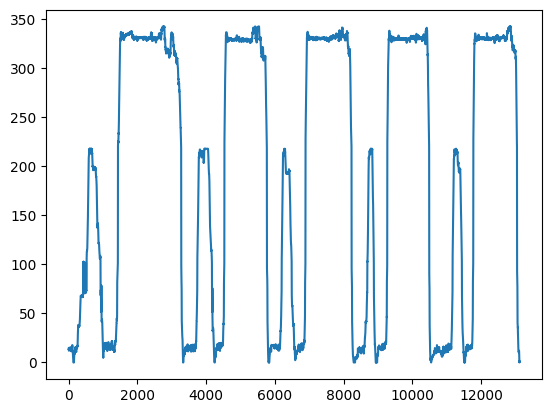

In [29]:
plt.plot(linear_pos)

## define decoding spaces and grid
To set up the encoding model, we first define the stimulus space, the spike amplitude space and the stimulus grid on which we will evaluate the posterior distribution.

In [10]:
# construct a encoded space for the subject's position with default kernel bandwidth
# using the precomputed squared distance matrix
space = compressed_kde.EncodedSpace("position", distances=distances, bandwidth=pos_bw)

# construct a coarse grid for evaluation by skipping N points in the fine grid
grid = space.grid(int(round(grid_resolution / fine_grid_resolution)))
grid_vector = fine_grid[:: int(round(grid_resolution / fine_grid_resolution))]

# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = compressed_kde.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)], bandwidth=[amp_bw,] * 4
)

In [11]:
grid_vector

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
       176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
       220., 224., 228., 232., 236., 240., 244., 248., 252., 256., 260.,
       264., 268., 272., 276., 280., 284., 288., 292., 296., 300., 304.,
       308., 312., 316., 320., 324., 328., 332., 336., 340.])

## convenience function for building decoder and binning data
For cross-validation, we need to rebuild the encoding model for different training data sets, and decode different test data sets. Below we define a decoder factory function that will accept all our stimulus and spike data and return a function that will build a new decoder for us given a set of training epochs.

In [36]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus, event_data in zip(
            kwargs["event_time"], kwargs["event_stimulus"], kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            L = decode.PoissonLikelihood(kwargs["event_space"], stim)
            L.add_events(
                np.concatenate(
                    (event_data[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)

        # build decoder from likelihoods
        decoder = decode.Decoder(likelihoods, [])

        return decoder

    return fcn

In [37]:
# let's use the factory function to create our decoder building function for our data
data = dict(stimulus_space=space, 
            grid=grid, 
            stimulus_duration=1./stim_sampling_frequency,
            compression=compression, 
            stimulus=pos, 
            stimulus_time=behavior['time'][:],
            event_time=tt_time, 
            event_data=tt_amp, 
            event_stimulus=tt_pos, 
            event_space=spike_space
           )

build_decoder = decoder_build_factory(**data)

In [16]:
tt_pos[0].shape

(13144, 1)

In [19]:
np.diff(tt_time[0])

array([0.006157, 0.018437, 0.032219, ..., 0.025938, 0.071656, 0.116781])

In [64]:
tt_pos[0]

array([[nan],
       [nan],
       [ 7.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

We will use the same factory approach for constructing the test data sets.

In [38]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s], :]
                for x, b in zip(kwargs["event_data"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [39]:
# let's use the factory function to create our data building function for our data
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=tt_amp)

build_data = data_build_factory(**data)

## perform cross-validation
Here we perform the cross-validation by looping through all trials and using the current trial to generate the test data set and the other trials to create the encoding model/decoder. Finally, we compute and collect the decoding error.

In [17]:
grid_vector

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
       176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
       220., 224., 228., 232., 236., 240., 244., 248., 252., 256., 260.,
       264., 268., 272., 276., 280., 284., 288., 292., 296., 300., 304.,
       308., 312., 316., 320., 324., 328., 332., 336., 340.])

In [40]:
# create lists for collecting real position, estimates and errors
reals = []
estimates = []
errors = []
posteriors = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)
    posteriors.append(posterior)
    
    # compute MAP estimates
    estimates.append(grid_vector[np.argmax(posterior, axis=1)])
    # determine real stimulus values
    reals.append(linear_pos_interpolator(decode_segments.center))
    # compute errors
    errors.append(
        np.abs(
            maze["maze"]["shapes"]["track"]["shape"].distance(estimates[-1], reals[-1])
        )
    )

estimates = np.concatenate(estimates)
reals = np.concatenate(reals)
errors = np.concatenate(errors)

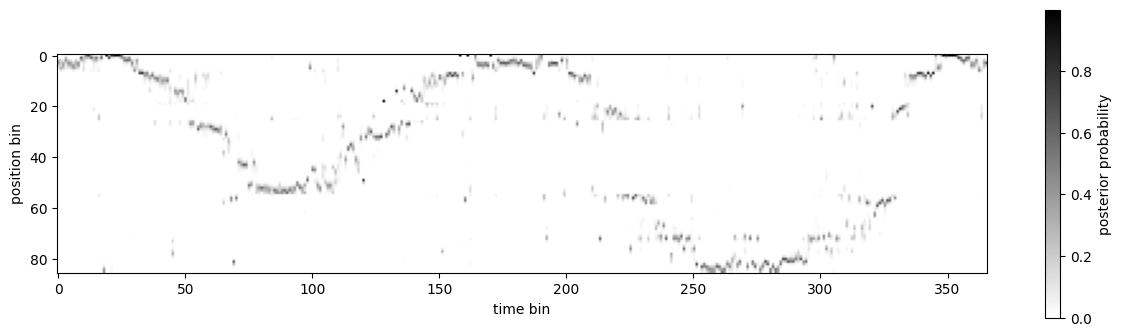

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[0].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability")

In [59]:
posteriors[0].shape

(366, 86)

## assess decoding results

In [16]:
# get borders between maze section in linearized position
nodes = np.cumsum(
    [0.0,] + maze["maze"]["shapes"]["track"]["shape"].edgelengths.tolist()
)
nsections = len(nodes) - 1

estimated_section = np.digitize(estimates, nodes) - 1
real_section = np.digitize(reals, nodes) - 1

# compute error statistics
median_error = np.median(errors)
correct = 100.0 * np.mean(estimated_section == real_section)

# compute error statistics per maze section
median_error_by_section = [
    np.median(errors[np.logical_and(reals >= nodes[k], reals < nodes[k + 1])])
    for k in range(nsections)
]
correct_by_section = [
    100.0 * np.mean(estimated_section[real_section == k] == k) for k in range(nsections)
]

overall median error is 5.8cm
median error per maze section is 5.2cm, 6.8cm, 5.5cm, 5.6cm, 7.0cm
overall % correct maze section is 89%
% correct per maze section is 89%, 65%, 86%, 90%, 93%


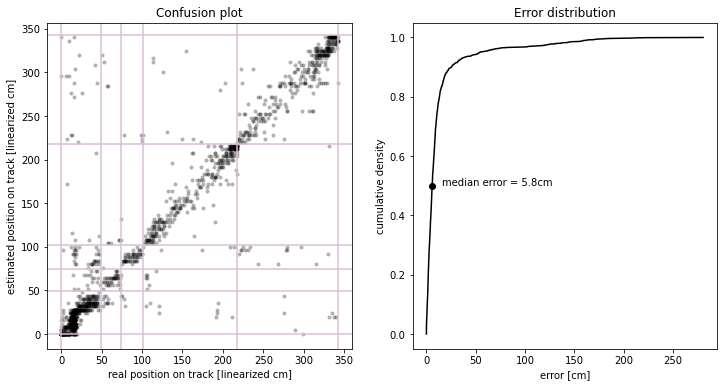

In [17]:
# plot confusion matrix: true position vs estimated position
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(reals, estimates, "ko", alpha=0.3, markersize=4, markeredgecolor="none")
ax[0].set_ylabel("estimated position on track [linearized cm]")
ax[0].set_xlabel("real position on track [linearized cm]")
ax[0].set_title("Confusion plot")

# plot maze section borders
for val in nodes:
    ax[0].axhline(val, color="thistle")
    ax[0].axvline(val, color="thistle")

# plot error distribution
def ecdf(x):
    return np.sort(x), np.arange(1, len(x) + 1, dtype=float) / len(x)


x, y = ecdf(errors)

ax[1].plot(x, y, "k")
ax[1].set_ylabel("cumulative density")
ax[1].set_xlabel("error [cm]")
ax[1].set_title("Error distribution")
ax[1].plot(median_error, 0.5, "ko")
ax[1].text(median_error + 10, 0.5, "median error = {0:0.1f}cm".format(median_error))

# print summary statistic
print("overall median error is {0:0.1f}cm".format(median_error))
print(
    "median error per maze section is "
    + ", ".join(["{0:0.1f}cm".format(x) for x in median_error_by_section])
)

print("overall % correct maze section is {0:0.0f}%".format(correct))
print(
    "% correct per maze section is "
    + ", ".join(["{0:0.0f}%".format(x) for x in correct_by_section])
)

## Save decoder

In [18]:
decoder_file = str(datafile.parent.joinpath("decoder.hdf5"))

# Save
decoder.save_to_hdf5(decoder_file)

## Test saved decoder

In [19]:
# load
z = decode.Decoder.load_from_hdf5(decoder_file)

In [20]:
test_trial = 0

# set training epochs to all trials except the test trial
training_epochs = run_epochs.intersection(
    trials[[trial for trial in range(ntrials) if trial != test_trial]]
)

# construct decoder for current training epochs
decoder = build_decoder(training_epochs)

In [21]:
# test data during run maze arm runs for test trial only
test_epochs = run_epochs.intersection(trials[test_trial])

# extract event data for each time bin
decode_segments, data = build_data(test_epochs)

# perform decoding and concatenate posteriors
zposterior = [z.decode(x, decode_bin, True) for x in data]
zposterior = np.vstack(zposterior)

posterior = [decoder.decode(x, decode_bin, True) for x in data]
posterior = np.vstack(posterior)

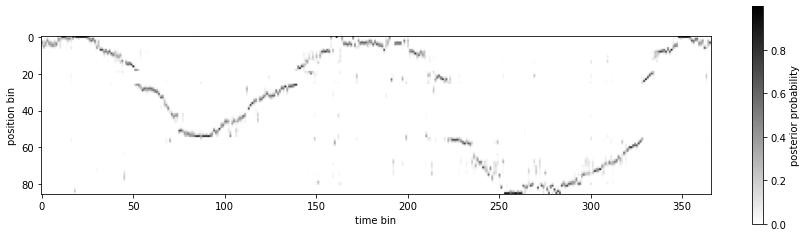

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(zposterior.T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

## Explore contents of saved HDF5 file

In [23]:
# define function to recursively get group keys
# based on: https://stackoverflow.com/a/59898173

def allkeys(obj, depth=100):
    "Recursively find all keys in an h5py.Group."
    keys = (obj.name,)
    
    if depth==0:
        return keys
    
    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + allkeys(value, depth-1)
            else:
                keys = keys + (value.name,)
    return keys    

In [24]:
hf = h5py.File(decoder_file, "r")

# look at top-level keys
print("Top level structure of file:\n")
for k in allkeys(hf,2):
    print(k)

Top level structure of file:

/
/likelihood
/likelihood/likelihood_0_0
/likelihood/likelihood_1_0
/likelihood/likelihood_2_0
/likelihood/likelihood_3_0
/likelihood/likelihood_4_0
/likelihood/likelihood_5_0
/likelihood/likelihood_6_0
/likelihood/likelihood_7_0
/likelihood/likelihood_8_0
/nsources
/nunion
/priors
/priors/prior0
/selection
/stimulus
/stimulus/stimulus_0_0


In [25]:
# Look at likelihood example
print("Structure of likelihood:\n")
for k in allkeys(hf['likelihood/likelihood_0_0'], 2):
    print(k)

Structure of likelihood:

/likelihood/likelihood_0_0
/likelihood/likelihood_0_0/event_distribution
/likelihood/likelihood_0_0/event_distribution/kernels
/likelihood/likelihood_0_0/event_distribution/nkernels
/likelihood/likelihood_0_0/event_distribution/space
/likelihood/likelihood_0_0/event_distribution/sum_of_nsamples
/likelihood/likelihood_0_0/event_distribution/sum_of_weights
/likelihood/likelihood_0_0/event_distribution/threshold
/likelihood/likelihood_0_0/event_distribution/weights
/likelihood/likelihood_0_0/random_insertion
/likelihood/likelihood_0_0/rate_scale


In [26]:
# look at space 

print("Structure of space:\n")
for k in allkeys(hf['stimulus/stimulus_0_0/stimulus_distribution/space']):
    print(k)
    
print("\nSpace class: {}".format(
    hf["stimulus/stimulus_0_0/stimulus_distribution/space/"].attrs['class']
))

Structure of space:

/stimulus/stimulus_0_0/stimulus_distribution/space
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel/bw
/stimulus/stimulus_0_0/stimulus_distribution/space/kernel/loc
/stimulus/stimulus_0_0/stimulus_distribution/space/space
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/info
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/info/cutoff
/stimulus/stimulus_0_0/stimulus_distribution/space/space/kernel/type
/stimulus/stimulus_0_0/stimulus_distribution/space/space/lut
/stimulus/stimulus_0_0/stimulus_distribution/space/space/name

Space class: encoded


In [27]:
# load only stimulus
stim = decode.Stimulus.load_from_hdf5(decoder_file, '/stimulus/stimulus_0_0')